# EdgeIIot dataset
## Preparing data
 
install and import dependecies

In [34]:
#!pip install pytorch-tabnet wget
#!pip install -U imbalanced-learn
#!pip install pydot
#!pip install graphviz
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from IPython.display import display; 
import os
import wget
from pathlib import Path
import shutil
import gzip
import pydot
from matplotlib import pyplot as plt
%matplotlib inline

random_state=42
np.random.seed(random_state)
sns.set(style="whitegrid")

# Load dataset

- Read the dataset;
- Drop columns
- Drop NA
- Drop duplicates

In [35]:
df = pd.read_csv('data/DNN-EdgeIIoT-dataset.csv', low_memory=False)

drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4", 
         "http.file_data","http.request.full_uri","icmp.transmit_timestamp",
         "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",
         "tcp.dstport", "udp.port", "mqtt.msg"]

df.drop(drop_columns, axis=1, inplace=True)

df.dropna(axis=0, how='any', inplace=True)

df.drop_duplicates(subset=None, keep="first", inplace=True)

In [36]:
categorical_columns = []
for col in df.columns[df.dtypes == object]:
    if col != "Attack_type":
        categorical_columns.append(col)

featuresFromStart = [ col for col in df.columns if col not in ["Attack_label"]+["Attack_type"]]
print("-----Features from the start-----")
print(featuresFromStart)
print("-----Categorial features-----")
print(categorical_columns)

-----Features from the start-----
['arp.opcode', 'arp.hw.size', 'icmp.checksum', 'icmp.seq_le', 'icmp.unused', 'http.content_length', 'http.request.method', 'http.referer', 'http.request.version', 'http.response', 'http.tls_port', 'tcp.ack', 'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'tcp.seq', 'udp.stream', 'udp.time_delta', 'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu', 'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request', 'dns.retransmit_request_in', 'mqtt.conack.flags', 'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg_decoded_as', 'mqtt.msgtype', 'mqtt.proto_len', 'mqtt.protoname', 'mqtt.topic', 'mqtt.topic_len', 'mqtt.ver', 'mbtcp.len', 'mbtcp.trans_id', 'mbtcp.unit_id']
-----Categorial features-----
['http.request.method', 'http.referer', 'http.request.version', 'dns.qry.name.len', 'mqtt.conack.flags', 'mqtt.protonam

In [5]:
#df = pd.get_dummies(df, columns=categorical_columns)
#featuresDummies = [ col for col in df.columns if col not in ["Attack_label"]+["Attack_type"]]
#print(featuresDummies)

In [37]:
#Display information about dataframe
def displayInformationDataFrame(df_cop):
    summary_df = pd.DataFrame(columns=['Data Type', 'Column Name', 'Unique Values'])
    # Iterate through the columns of the original dataframe
    for col in df_cop.columns:
        # Get the data type of the column
        dtype = df_cop[col].dtype
        # Get the column name
        col_name = col
        # Get the unique values of the column
        unique_values = df_cop[col].unique()
        # Append a new row to the summary dataframe
        summary_df = summary_df.append({'Data Type': dtype, 'Column Name': col_name, 'Unique Values': unique_values}, ignore_index=True)
    # display the summary_df
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    return display(summary_df)
    
displayInformationDataFrame(df)

,Data Type,Column Name,Unique Values
0,float64,arp.opcode,"[0.0, 1.0, 2.0]"
1,float64,arp.hw.size,"[0.0, 6.0]"
2,float64,icmp.checksum,"[0.0, 48853.0, 50901.0, 11938.0, 13986.0, 1418..."
3,float64,icmp.seq_le,"[0.0, 256.0, 48546.0, 32367.0, 58176.0, 3962.0..."
4,float64,icmp.unused,[0.0]
5,float64,http.content_length,"[0.0, 298.0, 303.0, 1465.0, 37.0, 1415.0, 38.0..."
6,object,http.request.method,"[0.0, 0, GET, POST, PROPFIND, TRACE, OPTIONS, ..."
7,object,http.referer,"[0.0, 0, TESTING_PURPOSES_ONLY, () { _; } >_[$..."
8,object,http.request.version,"[0.0, 0, HTTP/1.1, HTTP/1.0, name=a><input nam..."
9,float64,http.response,"[0.0, 1.0]"


In [38]:
colunas_one_hot = {}
for coluna in categorical_columns:
    codes, uniques = pd.factorize(df[coluna].unique())
    colunas_one_hot[coluna] = {"uniques": uniques, "codes":codes}
    df[coluna] = df[coluna].replace(colunas_one_hot[coluna]["uniques"], colunas_one_hot[coluna]["codes"])
    print(coluna)
df = pd.get_dummies(data=df, columns=categorical_columns)
displayInformationDataFrame(df)

http.request.method
http.referer
http.request.version
dns.qry.name.len
mqtt.conack.flags
mqtt.protoname
mqtt.topic


,Data Type,Column Name,Unique Values
0,float64,arp.opcode,"[0.0, 1.0, 2.0]"
1,float64,arp.hw.size,"[0.0, 6.0]"
2,float64,icmp.checksum,"[0.0, 48853.0, 50901.0, 11938.0, 13986.0, 1418..."
3,float64,icmp.seq_le,"[0.0, 256.0, 48546.0, 32367.0, 58176.0, 3962.0..."
4,float64,icmp.unused,[0.0]
5,float64,http.content_length,"[0.0, 298.0, 303.0, 1465.0, 37.0, 1415.0, 38.0..."
6,float64,http.response,"[0.0, 1.0]"
7,float64,http.tls_port,[0.0]
8,float64,tcp.ack,"[1.0, 15.0, 5.0, 56.0, 59.0, 0.0, 6.0, 3949528..."
9,float64,tcp.ack_raw,"[3153345534.0, 344794516.0, 3153345548.0, 3447..."


# Load data and split
Same split as in original paper

In [39]:
df = shuffle(df)
#split data
#X = df.iloc[:,0:46]
#for binary class
#Y_B = df.iloc[:,46]
#for multiclass 
#Y = df.iloc[:,47]
#df = df.sample(frac = 0.5, random_state = random_state)
n_total = len(df)

# Train, val and test split follows
features = [ col for col in df.columns if col not in ["Attack_label"]+["Attack_type"]] 

le = LabelEncoder()
le.fit(df["Attack_type"].values)
#0.9 so the train can have 0.1, so a smaller size
train_val_indices, test_indices = train_test_split(range(n_total), test_size=0.2, random_state=random_state)

X_train = df[features].values[train_val_indices]
y_train = df["Attack_type"].values[train_val_indices]
y_train = le.transform(y_train)

X_test = df[features].values[test_indices]
y_test = df["Attack_type"].values[test_indices]
y_test = le.transform(y_test)

# Simple preprocessing

In [40]:
standScaler = StandardScaler()
model_norm = standScaler.fit(X_train)

X_train = model_norm.transform(X_train)
X_test = model_norm.transform(X_test)

Do SMOTE in the trainning to make the dataset balanced

In [41]:
sm = SMOTE(random_state=random_state,n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)

/Users/melicias/.local/lib/python3.7/site-packages/imblearn/over_sampling/_smote/base.py:340: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  FutureWarning,


Ssave to csv files, so it easier to get everything

In [43]:
pd.DataFrame(X_train).to_csv('data/X_train_MultiClass.csv', header=None, index=None)
pd.DataFrame(y_train).to_csv('data/y_train_MultiClass'.csv, header=None, index=None)
pd.DataFrame(X_test).to_csv('data/X_test_MultiClass.csv', header=None, index=None)
pd.DataFrame(y_test).to_csv('data/y_test_MultiClass.csv', header=None, index=None) 

In [14]:
X_train = pd.read_csv('data/X_train_MultiClass.csv', low_memory=False).values
y_train = pd.read_csv('data/y_train_MultiClass.csv', low_memory=False).values.ravel()
X_test = pd.read_csv('data/X_test_MultiClass.csv', low_memory=False).values
y_test = pd.read_csv('data/y_test_MultiClass.csv', low_memory=False).values.ravel()

In [18]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
print(y_res)
print(X_res.shape)
print(len(features))

[0 0 0 ... 1 1 1]
(272234, 95)
95


In [22]:
def calcula_metricas(nome_modelo, ground_truth, predicao):
  """
    Funcão Auxiliar para calcular e imprimir métricas: Tx de Acerto, F1, 
    Precisão, Sensibilidade e AUC
  """
  acc = accuracy_score(y_true = ground_truth, y_pred = predicao)
  f1 = f1_score(y_true = ground_truth, y_pred = predicao)
  precision = precision_score(y_true = ground_truth, y_pred = predicao)
  recall = recall_score(y_true = ground_truth, y_pred = predicao)
  auc_sklearn = roc_auc_score(y_true = ground_truth, y_score = predicao)

  print(f"Desempenho {nome_modelo} - Conjunto de Teste")
  print(f' Taxa de Acerto: {np.round(acc*100,2)}%\n Precisão: {np.round(precision*100,2)}%')
  print(f' Sensibilidade: {np.round(recall*100,2)}%\n Medida F1: {np.round(f1*100,2)}%')
  print(f' Área sob a Curva: {np.round(auc_sklearn*100,2)}%')

In [45]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 50, random_state = random_state)
# Train the model on training data
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, random_state=42)

In [48]:
original_labels_list = le.classes_
print(original_labels_list)

['Backdoor' 'DDoS_HTTP' 'DDoS_ICMP' 'DDoS_TCP' 'DDoS_UDP' 'Fingerprinting'
 'MITM' 'Normal' 'Password' 'Port_Scanning' 'Ransomware' 'SQL_injection'
 'Uploading' 'Vulnerability_scanner' 'XSS']


              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4816
           1       0.93      0.55      0.69      9634
           2       1.00      1.00      1.00     13624
           3       1.00      1.00      1.00      9973
           4       1.00      1.00      1.00     24435
           5       0.25      0.81      0.38       206
           6       1.00      1.00      1.00        82
           7       1.00      1.00      1.00    272753
           8       0.54      0.77      0.63      9998
           9       0.97      0.87      0.92      4029
          10       0.87      0.91      0.89      1996
          11       0.64      0.54      0.59     10131
          12       0.72      0.45      0.56      7290
          13       0.98      0.89      0.93      9975
          14       0.34      0.90      0.49      2993

    accuracy                           0.95    381935
   macro avg       0.81      0.84      0.80    381935
weighted avg       0.96   

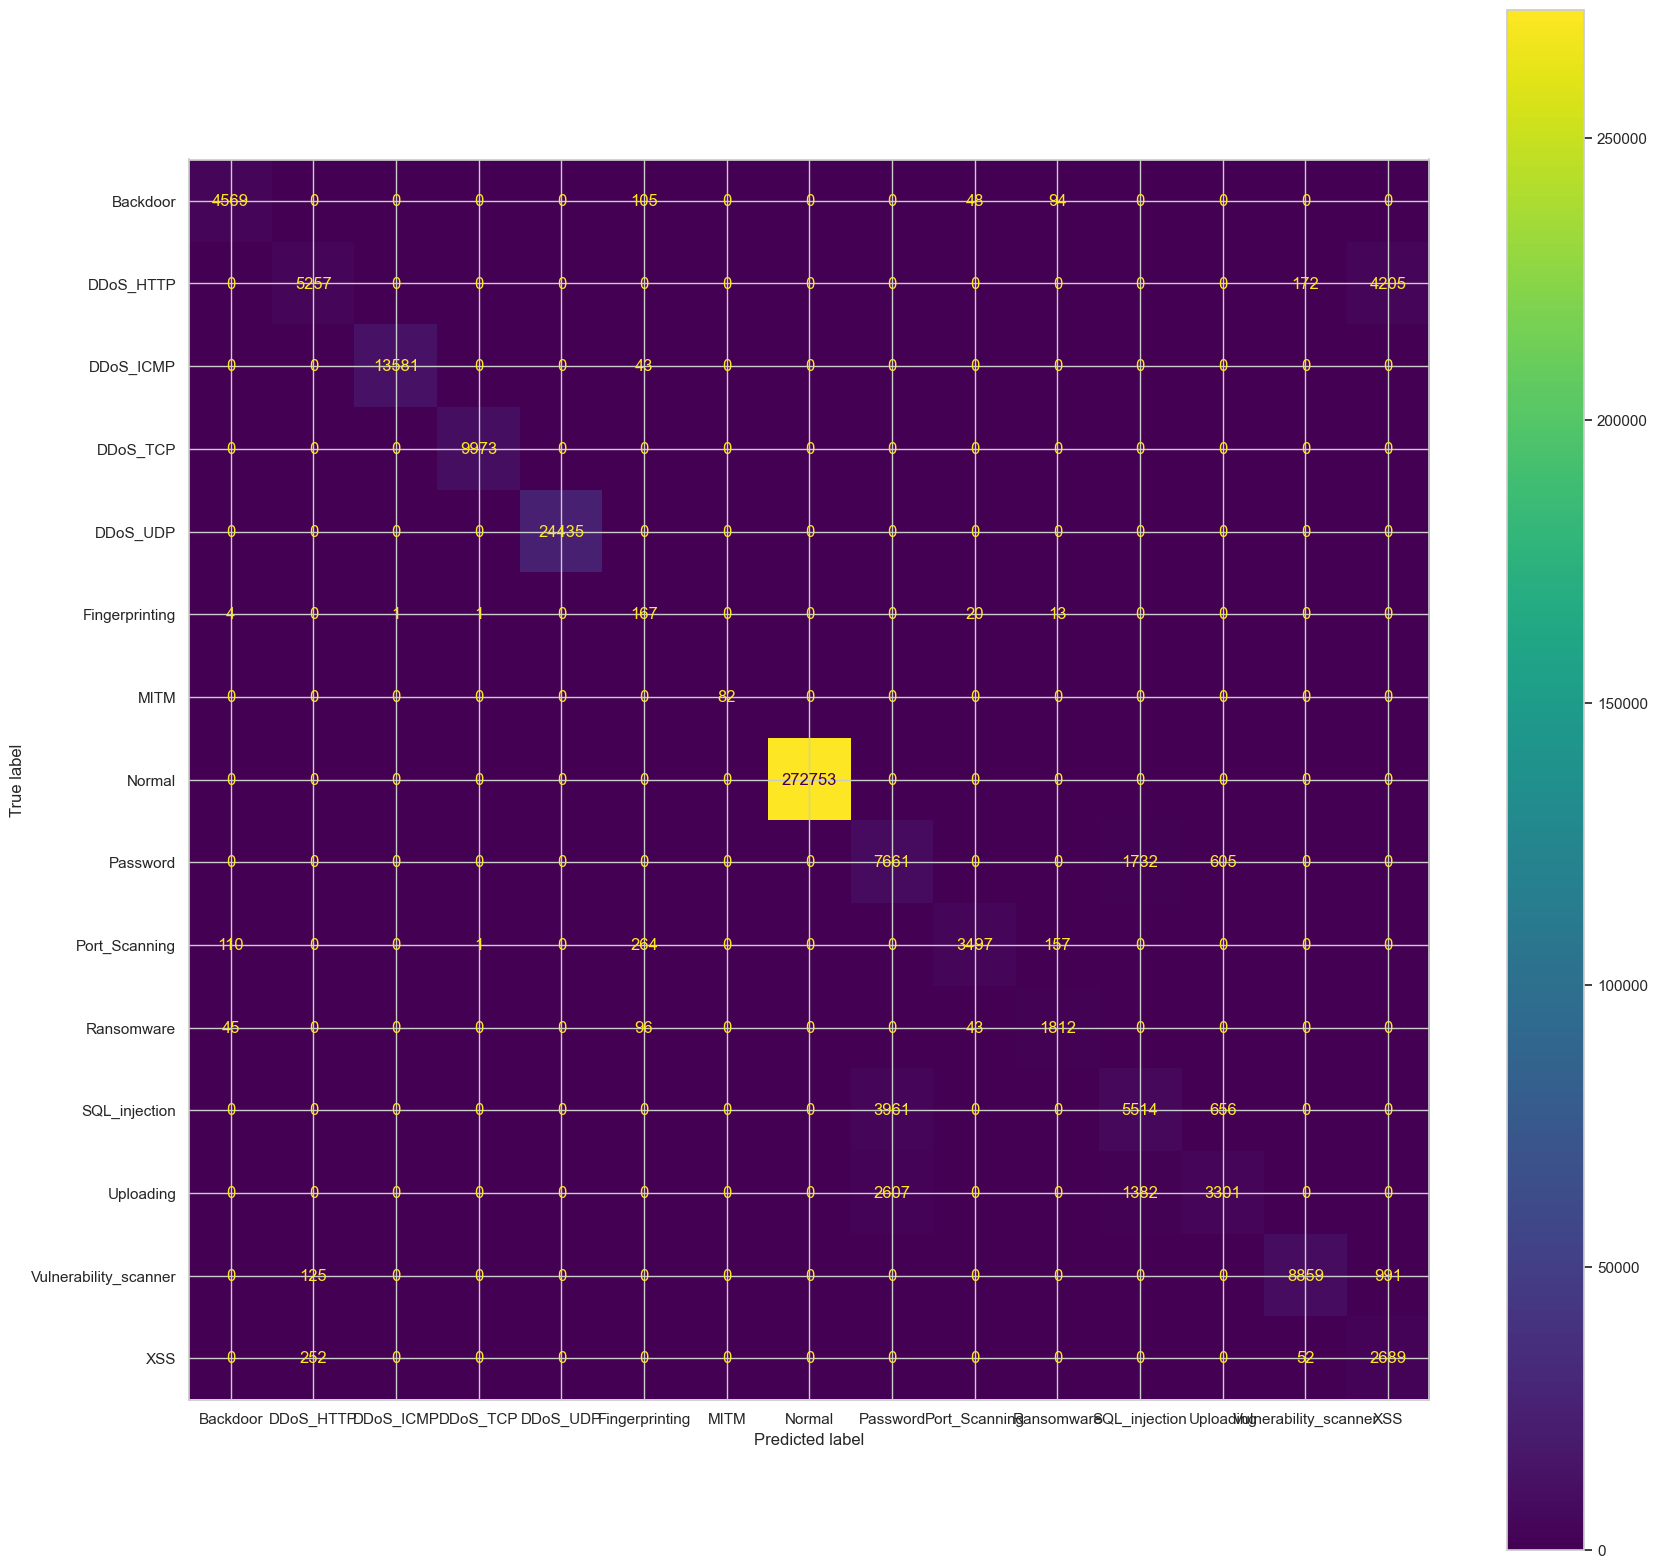

In [79]:
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))

mask = np.logical_not(np.equal(y_test, predictions))
print(f"Elements wrong classified: {len(X_test[mask])}; Elements correct: {len(X_test) - len(X_test[mask])}")

fig,ax = plt.subplots(figsize=(20, 20))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels= original_labels_list)
cm_display.plot(ax=ax)
plt.savefig("confusion_matrix.png")
plt.show()

In [80]:
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'treeMulti.dot', feature_names = features, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('treeMulti.dot')
# Write graph to a png file
graph.write_png('treeMulti.png')

Exception ignored in: <function Comm.__del__ at 0x7fde20faf830>
Traceback (most recent call last):
  File "/Users/melicias/opt/anaconda3/envs/tabnet/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 81, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: 

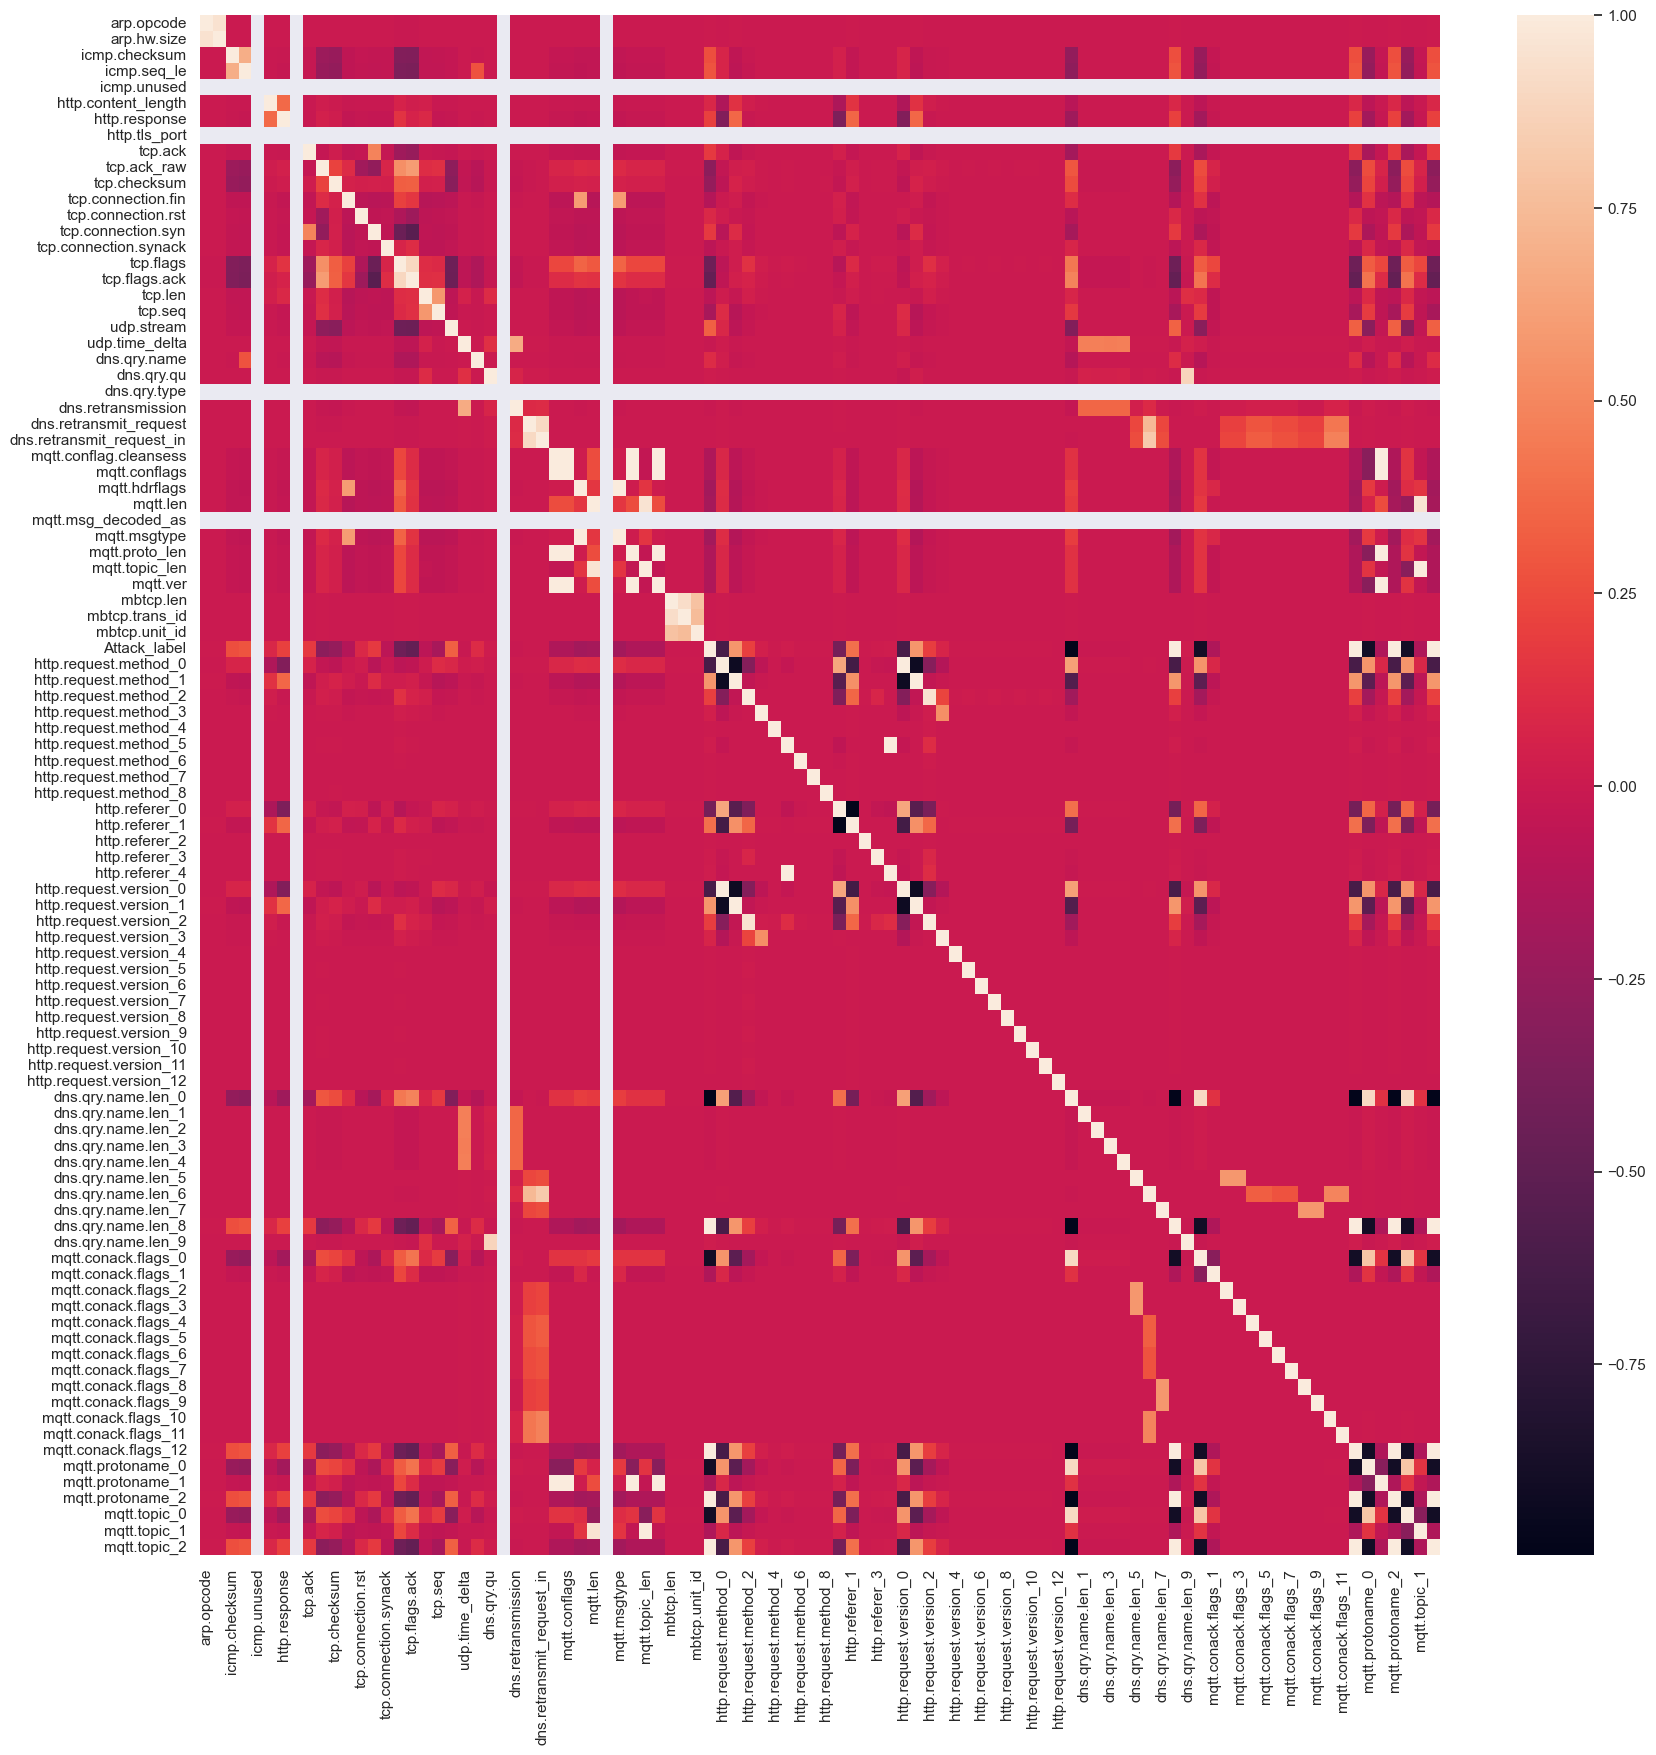

                           arp.opcode  arp.hw.size  icmp.checksum  \
arp.opcode                   1.000000     0.949999      -0.000572   
arp.hw.size                  0.949999     1.000000      -0.000602   
icmp.checksum               -0.000572    -0.000602       1.000000   
icmp.seq_le                 -0.000619    -0.000651       0.681079   
icmp.unused                       NaN          NaN            NaN   
http.content_length         -0.000185    -0.000195      -0.008943   
http.response               -0.000453    -0.000477      -0.021921   
http.tls_port                     NaN          NaN            NaN   
tcp.ack                     -0.000513    -0.000540      -0.024809   
tcp.ack_raw                 -0.004575    -0.004816      -0.221390   
tcp.checksum                -0.004946    -0.005206      -0.239326   
tcp.connection.fin          -0.001152    -0.001212      -0.055727   
tcp.connection.rst          -0.000757    -0.000797      -0.036630   
tcp.connection.syn          -0.000

In [82]:
sns.set(rc = {'figure.figsize':(20,20)})
sns.heatmap(df.corr())
plt.show()
print(df.corr())

In [83]:
sns.set(rc = {'figure.figsize':(15,17)})
sns.pairplot(df, hue="Attack_type")
plt.show()

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fde0ab1a680> (for post_execute):


KeyboardInterrupt: 